Описание проекта "Определение стоимости автомобилей"

**Задача:**

Построить модель для определения рыночной стоимости автомобиля. Модель выбирается с учетом:
- качества предсказания. Для оценки качества моделей метрику используем RMSE
- скорости предсказания;
- времени обучения.

**Данные:**

В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. 

Данные находятся в файле /datasets/autos.csv.

**План проекта:**

- Загрузка и просмотр данных
- Анализ и предобработка данных
- Обучим разные модели. Для каждой попробуем различные гиперпараметры.
- Проанализируем скорость работы и качество моделей.
- Выводы


In [4]:
import pandas as pd #loading the necessary libraries
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import time
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from catboost import Pool, CatBoostRegressor, cv
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

## Загрузка и просмотр данных¶

In [5]:
df = pd.read_csv("autos.csv") #/datasets/autos.csv
def count_nans(df):
    '''a function that calculates the number and percentage of missing values in the dataframe
    input: dataframe '''
    print('Столбцы, имеющие пропушенные значения:')
    nan_df = df.isna().sum().to_frame(name="nans").query("nans > 0")["nans"].reset_index() #create frame with number of nan-values for each column
    nan_df['nans%'] = nan_df['nans'].apply(lambda x: round(x*100/len(df),2)) #add column with % of nan-values
    display(nan_df)
    
def info(df):
    '''a function that summarizes the information about the dataframe: 
    - the first 5 rows of the dataframe, 
    - general information, 
    - table of missing values, 
    - the number of repetitions in the table
    input: dataframe'''
    display(df.head())
    df.info()
    count_nans(df)
    print(f'Повторы в таблице: {df.duplicated().sum()}')
info(df)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,index,nans,nans%
0,VehicleType,37490,10.58
1,Gearbox,19833,5.60
2,Model,19705,5.56
3,FuelType,32895,9.28
4,NotRepaired,71154,20.08


Повторы в таблице: 4


<a id = 'data_preparation'></a>
<div style = 'border: solid green 2px; padding: 20px'>
    
    
Датафрейм сотоит из 16 столбцов и 354369 наблюдений (строчек).

Признаки:
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Целевой признак:
- Price — цена (евро)

Названия столбцов не содержат пробелов, все знаки в разных регистрах. Для дальнейшего удобства работы с данными заменим на нижний регистр.

Есть категориальные и количественные данные, также присутствуют данные булева типа.

Есть пропуски в 5 столбцах таблицы, о них подробнее ниже.

Типы столбцов соответствуют информации хранящихся в них. Исключения составляют даты, имеющие тип object.

Есть 4 повторяющихся наблюдения. Удалим их.

Для построения модели, определяющей рынучную стоимость автомобиля, нужны не все признаки присутствующие в датафрейме. Удалим ненужные.

## Анализ и предобработка данных

Для удобства поменяем названия столбцов на нижний регистр.

In [6]:
df.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', name).lower() for name in df.columns]

Удалим дубликаты в таблице.

In [7]:
df.drop_duplicates(inplace = True) #delete duplicates

Оставим в нашей таблице только те столбцы, которые нужны для построения прогнозов цен автомобилей.

In [8]:
df_model = df.copy().drop(columns = ['date_crawled', 'registration_month', 'date_created', 'number_of_pictures', 'postal_code', 'last_seen']) 
df_model.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


### Признак `brand`

In [9]:
df_model.brand.unique()

array(['volkswagen', 'audi', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'opel', 'seat',
       'citroen', 'honda', 'fiat', 'mini', 'smart', 'hyundai',
       'sonstige_autos', 'alfa_romeo', 'subaru', 'volvo', 'mitsubishi',
       'kia', 'suzuki', 'lancia', 'toyota', 'chevrolet', 'dacia',
       'daihatsu', 'trabant', 'saab', 'chrysler', 'jaguar', 'daewoo',
       'porsche', 'rover', 'land_rover', 'lada'], dtype=object)

Пропущенных данных в столбце нет. Все бренды узнаваемы. 

### Признак `model`

In [10]:
df_model.model.unique()

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'meriva', 'arosa', 'c4', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'corsa', 'one',
       'fortwo', '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta',
       'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
       '100', 'z_reihe', 'sportage', 'sorento', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'a3', 'almera', 'megane', 'lupo', 'r19',
       'zafira', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'berlingo', 'tiguan', 'i_reihe', 'espace', 'sharan',
       '6_reihe', 'panda', 'up', 'seicento', 'ceed', '5_reihe', 'yeti',
       'octavia', 'mii', 'rx_reihe', '6er', 'modus', 'fox'

С моделями машин посложнее чем с брендами. Их много.
- есть пропущенные значения. заменим из на 'unknown'
- 'range_rover' и 'rangerover' 2 разных написания одной модели. заменим.

In [11]:
df_model['model'] = df_model.model.replace('rangerover', 'range_rover')
df_model['model'] = df_model['model'].fillna('uknown')

### Целевой признак `price`

In [12]:
df_model.price.describe()

count    354365.000000
mean       4416.679830
std        4514.176349
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: price, dtype: float64

В столбце `price` минимальное значение 0. так дешево навряд ли будут продавать машины, скорее всего данные испорчены. Поскольку это целевой признак, то никак заполнить его мы не можем, удалим данные для которых цена очень низкая (около 0).

In [13]:
print(f'Квантиль 5% = {df_model.price.quantile(0.05)} евро')

Квантиль 5% = 200.0 евро


За такую стоимость можно купить какую-нибудь разбитую машину. Поэтому удалим данные о цене менее 200 евро. Потеря 5% наших данных приемлема.

In [14]:
df_model = df_model[(df_model.price>200)]
df_model.price.describe()

count    334917.000000
mean       4669.992094
std        4515.700301
min         202.000000
25%        1299.000000
50%        2990.000000
75%        6700.000000
max       20000.000000
Name: price, dtype: float64

### Признак `vehical_type`

Данные в этом столбце имеют чуть больше 10% пропущенных значений.

Заполним пропущенные данные наиболее часто встречающимся значением для данной модели, данного бренда. (например, модель 145 бренда alfa_romeo имеет 3 типа кузова: coupe, other, sedan, small - чаще всего встречается кузов small. Поэтому пропущенный тип кузова для данной модели заменим на small)


In [15]:
df_model['vehicle_type'] = df_model['vehicle_type'].fillna(df_model.groupby(['model','brand'])
                                                           .vehicle_type.transform(lambda x: x.value_counts().idxmax()))                                               

### Столбец `registration_year`

In [16]:
df_model.registration_year.describe()

count    334917.000000
mean       2003.977920
std          67.384499
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: registration_year, dtype: float64

Столбец отвечающий за информацию о годе регистрации имеет аномальные значения: минимальное значение 1000, максимальное 9999.

Автомобили стали вводить в эксплуатацию лишь в 20 веке, поэтому регистрационный год должен быть не меньше 1900 года.

Посмотрим крайний год создания анкет в исходном датафрейме, регистрационный год не должен быть больше этого значения.

In [17]:
df['date_created'] = pd.to_datetime(df['date_created'], format='%Y-%m-%dT%H:%M:%S')
print(f"Крайний год, создания анкеты: {df.date_created.dt.to_period('Y').max()}")

Крайний год, создания анкеты: 2016


In [18]:
print(f'Процент наблюдений, в которых год регистрации аномален: {len(df_model[(df_model.registration_year<1900)|(df_model.registration_year>2016)])/len(df_model):.2%}')

Процент наблюдений, в которых год регистрации аномален: 4.06%


Считаю, что эти данные можно удалить. Удалим данные с аномальными значениями года регистрации автомобиля.

In [19]:
df_model = df_model[(df_model.registration_year>=1900)&(df_model.registration_year<=2016)]

### Столбец `gearbox`

In [20]:
df_model.gearbox.value_counts(dropna = False)

manual    245193
auto       62521
NaN        13589
Name: gearbox, dtype: int64

Поскольку автоматическая коробка передач пришла в серийное производство только в 1947 году, то заменим пропущенные значения для рассмативаемого столбца на 'manual' для машин с годом регистрации меньше 1947. Все остальные пропущенные значения заменим на 'unknown'

In [21]:
df_model.loc[df_model.registration_year<1947, 'gearbox'] = 'manual'
df_model['gearbox'] = df_model.gearbox.fillna('unknown')
df_model.gearbox.value_counts(dropna = False)

manual     245224
auto        62520
unknown     13559
Name: gearbox, dtype: int64

### Столбец `fuel_type`

Заменим пропущенные значения этого столбца на 'unknown'

In [22]:
df_model['fuel_type'] = df_model.fuel_type.fillna('unknown')
df_model.fuel_type.value_counts(dropna = False)

petrol      199285
gasoline     94477
unknown      21584
lpg           4990
cng            527
hybrid         218
other          138
electric        84
Name: fuel_type, dtype: int64

### Столбец `power`

Теперь разберемся с данными по столбцу `power` - мощность автомобиля в лошадинных силах. Этот признак можно ограничить снизу 30л.с и 2000л.с сверху.
Также посчитаем какой процент таких данных. Заменим их на nan-values.

In [23]:
print(f'Процент наблюдений, в которых мощность аномалена: {len(df_model[(df_model.power<30)|(df_model.power>2000)])/len(df_model):.2%}')

Процент наблюдений, в которых мощность аномалена: 9.50%


In [24]:
df_model.loc[df_model.power<30, 'power'] = np.nan
df_model.loc[df_model.power>2000, 'power'] = np.nan

Теперь данные в этом столбце имеют 9.5% пропущенных значений.

Заполним пропущенные данные наиболее часто встречающимся значением для похожей машины (должны совпадать бренд, модель, кузов, год выпуска, коробка передач, топливо), если нет аналогичных машин - заменяем на nan-values.

In [25]:
df_model['power'] = df_model['power'].fillna(df_model.groupby(['brand','model','vehicle_type','registration_year', 'gearbox', 'fuel_type'])
                                             .power.transform(lambda x: x.value_counts().idxmax() if x.value_counts().size!=0 else np.NaN))    

In [26]:
count_nans(df_model) #count the remaining missing values

Столбцы, имеющие пропушенные значения:


,index,nans,nans%
0,power,7568,2.36
1,not_repaired,55718,17.34


Удалим оставшиеся пропущенные значения в столбце power.

In [27]:
df_model.dropna(subset= ['power'], inplace = True) #delete remaining missing values in column power

### Столбец `kilometer`

count    313735.000000
mean     128648.684399
std       36676.016679
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: kilometer, dtype: float64


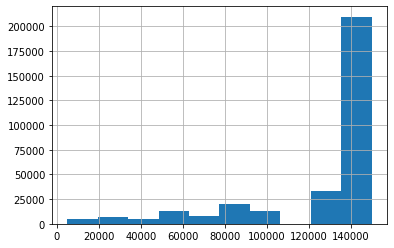

In [28]:
print(df_model.kilometer.describe())
df_model.kilometer.hist()
plt.show()

Нет пропущенных значений. Достаточно реальные значения.

### Признак `not_repaired`

Пропущенные значения этого признака заменим на 'unknown'

In [29]:
df_model['not_repaired'] = df_model['not_repaired'].fillna('unknown')

Проверим наличие пропущенных значений после предобработки.

In [30]:
count_nans(df_model)

Столбцы, имеющие пропушенные значения:


,index,nans,nans%


Проверим зависимость между признаками.

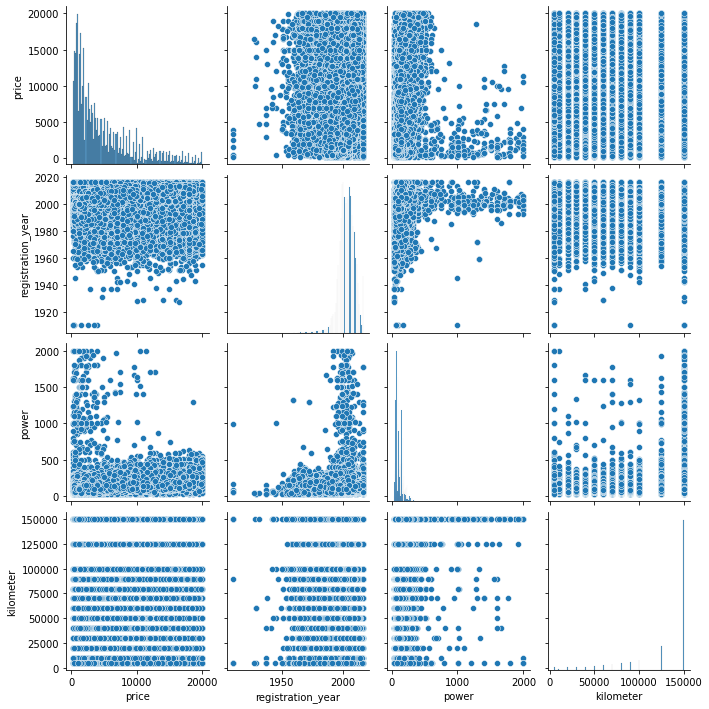

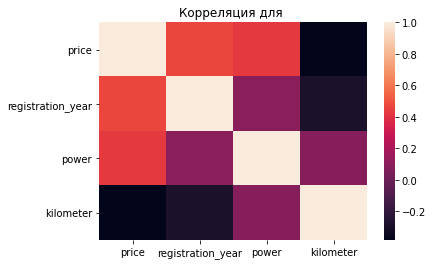

In [31]:
sns.pairplot(df_model)
plt.show()
sns.heatmap(df_model.corr())
plt.title(f'Корреляция для ')
plt.show()

<a id = 'data_preparation'></a>
<div style = 'border: solid green 2px; padding: 20px'>
    
**Вывод:**
    
   В рамках предобработки данных были выполнены следующие шаги:
    
   - названия столбцов переведены в нижний регистр
   - удалены дубликаты
   - удалены столбцы ненужные для построения модели
   - оставшиеся столбцы были рассмотрены на наличие артефактов и пропущенных значений. Артефакты ликвидированы, пропущенные значения удалены либо заполнены.
     
Рассмотрена связь между признаками:
    
   - как видно из гистограмм pairplota в данных присутствуют выбросы, они могут отрицательно повлиять на качество моделей. Но удалять мы их не можем, поскольку они могут содержать важные данные (например, информацию о дорогих машинах или о машинах с маленьким пробегом. такие даные имеют место быть)  
   - выбросы `registration_year` тоже принято оставить, хотя стоит уточнить у заказчика, будет ли приложение работаеть с раритетными автомобилями или лучше ограничить год выпуска машин. 
   - мультиколлинеарных признаков не обнаружено
    

## Обучение моделей

Обучим и сравним результаты и скорость работы следующих моделей:

- LinearRegression
- DecisionTreeRegressor
- CatBoostRegressor
- LGBMRegressor

В качестве метрики для всех моделей будем использовать RMSE. Качество моделей будем проверять на кросс-валидации.

Подготовим данные для обучения.

In [32]:
cat_features = ['brand', 'model', 'vehicle_type', 'gearbox', 'fuel_type', 'not_repaired']

features = df_model.drop('price', axis = 1) #split features-target #features for CatBoost regression
target = df_model['price']

features_ohe = features.copy() # prepare features for linear regression and decision tree regression
features_ohe = pd.get_dummies(features, drop_first = True) # ohe-coding categorical features

features_light = features.copy() # prepare features for lightGBM regression 
features_light = features_light.astype({"vehicle_type":'category',
                                  "gearbox":'category',
                                  "model":'category',
                                  "fuel_type":'category',
                                  "brand":'category',
                                  "not_repaired":'category'})

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size = .25, random_state = 12345) #split train-test

features_train_ohe = features_ohe.loc[features_train.index, :] #split train-test for ohe-coding features
features_test_ohe = features_ohe.loc[features_test.index, :]

features_train_light = features_light.loc[features_train.index, :]#split train-test light features
features_test_light = features_light.loc[features_test.index, :]

print(features_train.shape, target_train.shape) #check the shape
print(features_test.shape, target_test.shape)
print(features_train_ohe.shape, target_train.shape)
print(features_test_ohe.shape, target_test.shape)
print(features_train_light.shape, target_train.shape)
print(features_test_light.shape, target_test.shape)

(235301, 9) (235301,)
(78434, 9) (78434,)
(235301, 308) (235301,)
(78434, 308) (78434,)
(235301, 9) (235301,)
(78434, 9) (78434,)


In [33]:
def rmse(target, predict):
    """function that calculate Root Mean Squared Error
    input: target values, predict values
    output: RMSE"""
    return mean_squared_error(predict,target)**0.5

rmse_score = make_scorer(rmse, greater_is_better=False) # make own scorer

In [34]:
def model(model_name, parameters, features_train):
    model = GridSearchCV(model_name, param_grid=parameters, scoring=rmse_score, cv=5) 
    model.fit(features_train, target_train) 
    print('Модель:', model.best_estimator_)
    print('Параметры модели: ', model.best_params_)
    print('RMSE = ', (model.best_score_*-1))
    return model.best_estimator_

### Linear Regression

**Линейная регрессия с нормализацией**

In [35]:
%%time
ss = StandardScaler()
features_train_ohe_scaled = ss.fit_transform(features_train_ohe)
features_test_ohe_scaled = ss.transform(features_test_ohe)
model_LR = LinearRegression()
model_LR.fit(features_train_ohe_scaled, target_train) 
predicted = model_LR.predict(features_train_ohe_scaled)
score_LR = rmse(target_train, predicted)
print('Модель:', model_LR)
print('RMSE = ', score_LR)

Модель: LinearRegression()
RMSE =  2713.8220643311597
CPU times: total: 21.8 s
Wall time: 5.07 s


**Линейная Регрессия без нормализации**

In [36]:
%%time

model_LR = LinearRegression()
model_LR.fit(features_train_ohe, target_train) 
predicted = model_LR.predict(features_train_ohe)
score_LR = rmse(target_train, predicted)
print('Модель:', model_LR)
print('RMSE = ', score_LR)

Модель: LinearRegression()
RMSE =  2713.819983764473
CPU times: total: 21.5 s
Wall time: 3.78 s


### Decision Tree Regressor

In [37]:
%%time

params_DT = {'max_depth': range(5, 30)}
model_DT = model(DecisionTreeRegressor(random_state = 12345), params_DT, features_train_ohe)

Модель: DecisionTreeRegressor(max_depth=18, random_state=12345)
Параметры модели:  {'max_depth': 18}
RMSE =  1852.6284276891347
CPU times: total: 6min 36s
Wall time: 10min 44s


### CatBoost Regressor

In [38]:
%%time

params_CB = {'learning_rate':[0.5, 0.8], 
              'depth': [6, 10, 20], 
              'l2_leaf_reg': [1, 3, 5, 7, 9], 
              'iterations': [100]}
model_CB = model(CatBoostRegressor(random_state = 12345, cat_features = cat_features, verbose = 0), params_CB, features_train)

Модель: <catboost.core.CatBoostRegressor object at 0x000002510231AAC0>
Параметры модели:  {'depth': 10, 'iterations': 100, 'l2_leaf_reg': 3, 'learning_rate': 0.5}
RMSE =  1599.1835186510918
CPU times: total: 6min 57s
Wall time: 15min 50s


### LightGBM Regressor

In [ ]:
%%time

params_LGBM = {'max_depth': [50, 75, 150], 
               'learning_rate': [0.01, 0.1, 0.5], 
               'num_leaves': [500, 1200], 
               'n_estimators':[50, 100, 200]}
model_LGBM = model(LGBMRegressor(random_state = 12345), params_LGBM, features_train_light)


## Сравнение моделей

Итак, мы определили гиперпараметры и качество модели на кросс-валидации.

Теперь протестируем лучшие модели на тестовой выборке и проведем их проверку на адекватность.

In [ ]:
start = time.time()

DR = DummyRegressor(strategy="median")
DR.fit(features_train, target_train)
predict_DR= DR.predict(features_test)
score_dummy = rmse(target_test, predict_DR)
print('RMSE Dummy регрессора =', score_dummy)
dict_DR = {'Dummy Regressor': score_dummy}

end = time.time()
time_DR = end - start
print('Wall time', time_DR)

In [ ]:
def test_model(name_model, best_model, features_train, features_test):
    """function that checks the model on the test set
    input:  name_model - string
            best_model - model 
            features_train 
            features_test
    output: dictionary with name of the model and its  RMSE score"""
    model = best_model
    model.fit(features_train, target_train)
    predicted = model.predict(features_test)
    score = rmse(target_test, predicted)
    print(best_model)
    print('RMSE = ', score)
    dict_model_score = {name_model:score}
    return dict_model_score

In [ ]:
start = time.time()

dict_LR = test_model('Linear Regression', model_LR, features_train_ohe, features_test_ohe)

end = time.time()
time_LR = end - start
print('Wall time', time_LR)

In [ ]:
start = time.time()

dict_DT = test_model('Decision Tree Regressor', model_DT, features_train_ohe, features_test_ohe)

end = time.time()
time_DT = end - start
print('Wall time', time_DT)

In [ ]:
start = time.time()

dict_CB = test_model('CatBoost Regressor', model_CB, features_train, features_test)

end = time.time()
time_CB = end - start
print('Wall time', time_CB)

In [ ]:
start = time.time()

dict_LGBM = test_model('Light GBM Regressor', model_LGBM, features_train_light, features_test_light)

end = time.time()
time_LGBM = end - start
print('Wall time', time_LGBM)

In [ ]:
dict_time = {'Dummy Regressor': time_DR, 'Linear Regression': time_LR, 'Decision Tree Regressor': time_DT, 
             'CatBoost Regressor': time_CB, 'Light GBM Regressor': time_LGBM}
dict_scores = {**dict_DR, **dict_LR, **dict_DT, **dict_CB, **dict_LGBM}
table_scores = pd.DataFrame(dict_scores, index = ['RMSE score']).T.reset_index()
table_time = pd.DataFrame(dict_time, index = ['time(sec)']).T.reset_index()
comparison_table = table_scores.merge(table_time, how = 'outer')
comparison_table.rename(columns = {'index':'model'}, inplace = True)
comparison_table

<a id = 'data_preparation'></a>
<div style = 'border: solid green 2px; padding: 20px'>
    
**Вывод:**
    
- Oбучены четыре модели:  Линейная регрессия, Случайный лес, CatBoost Регрессия, LGBM Регрессия
- Найдены оптимальные гиперпараметры для каждой модели
- Модели с оптимальными гиперпараметры протестированы на тестовом наборе данных
- Проведено сравнение моделей по скорости работы и качества предсказания
- Проверена адекватность всех моделей(сравнение с константной)
- Наименьший показатель метрики RMSE = 1487.79 достигнут при использовании модели LightGBM Regressor
- Самая быстрая модель  - Линейная регрессия.Но у нее очень плохое качество предсказания по сравнению с остальными моделями.
- LightGBM Regressor чемпион по качеству и времени работы.
- Для работы рекомендуется применять модель на основе LightGBM Regressor.
